In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [2]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

# Schema Set

In [3]:
input = 'EDS_13.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

# Initial Filter to obtain useful Data. Other ranges are useless

In [5]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,(Z*-1) as Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

# Standard Scaler - Z normalization

In [6]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 14:26:...|1.160156| 0.139341|
|2018-07-09 22:59:...| 1.15625| -0.15171|
|2018-07-10 03:09:...|1.160156| 0.139341|
|2018-07-09 14:59:...| 1.15625| -0.15171|
|2018-07-09 19:35:...|1.152344|-0.442761|
|2018-07-10 02:04:...|1.152344|-0.442761|
|2018-07-09 14:06:...|1.066406|-6.846325|
|2018-07-10 01:14:...|1.160156| 0.139341|
|2018-07-09 16:31:...|1.160156| 0.139341|
|2018-07-09 21:44:...| 1.15625| -0.15171|
|2018-07-09 12:48:...| 1.15625| -0.15171|
|2018-07-09 20:08:...|1.152344|-0.442761|
|2018-07-09 19:40:...|1.152344|-0.442761|
|2018-07-10 01:06:...| 1.15625| -0.15171|
|2018-07-09 18:42:...|1.226563| 5.087576|
|2018-07-09 23:42:...|1.152344|-0.442761|
|2018-07-10 00:34:...| 1.15625| -0.15171|
|2018-07-10 01:44:...|1.160156| 0.139341|
|2018-07-09 20:49:...|1.152344|-0.442761|
|2018-07-10 01:50:...| 1.15625| -0.15171|
+--------------------+--------+---

# Exploratory Findings

In [7]:
#Below code is to find distribution of values for the entire filtered time period. This might help in finding 
#frequent model cases
#Round the Zscale value to 0
scaledData.createOrReplaceTempView("scaledData")
scaledNorm = spark.sql("select timestamp,Z,Zscale,round(Zscale,0) as Zround from scaledData ORDER BY Zround DESC")
scaledNorm.show(200)
#Select only rounded values
scaledNorm.createOrReplaceTempView("scaledNorm")
scaledRound = spark.sql("select distinct(Zround),count(Zround) from scaledNorm group by Zround")
scaledRound.show()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-08-01 06:44:...| 1.59375|32.448061|  32.0|
|2018-08-01 06:44:...|  1.5625|30.119506|  30.0|
|2018-08-01 06:44:...|1.550781| 29.24628|  29.0|
|2018-08-01 06:44:...|1.539063|28.373127|  28.0|
|2018-08-01 06:44:...|1.496094|25.171345|  25.0|
|2018-08-01 06:44:...|1.472656|23.424892|  23.0|
|2018-08-01 06:44:...|1.386719|17.021402|  17.0|
|2018-07-16 07:36:...|1.371094|15.857125|  16.0|
|2018-08-01 06:44:...|1.359375|14.983898|  15.0|
|2018-08-01 06:44:...|1.355469|14.692847|  15.0|
|2018-08-01 06:44:...|1.328125|12.655343|  13.0|
|2018-07-27 12:13:...|1.300781|10.617839|  11.0|
|2018-07-20 07:18:...|1.300781|10.617839|  11.0|
|2018-08-01 06:44:...|1.292969|10.035737|  10.0|
|2018-08-01 06:44:...|1.277344|  8.87146|   9.0|
|2018-07-23 13:47:...|1.273438| 8.580409|   9.0|
|2018-08-02 14:34:...|1.273438| 8.580409|   9.0|
|2018-07-19 16:39:..

+------+-------------+
|Zround|count(Zround)|
+------+-------------+
|  32.0|            1|
|  30.0|            1|
|  29.0|            1|
|  28.0|            1|
|  25.0|            1|
|  23.0|            1|
|  17.0|            1|
|  16.0|            1|
|  15.0|            2|
|  13.0|            1|
|  11.0|            2|
|  10.0|            1|
|   9.0|           14|
|   8.0|         1458|
|   7.0|       231246|
|   6.0|       333440|
|   5.0|       198929|
|   4.0|       100773|
|   3.0|        98790|
|   2.0|       184306|
+------+-------------+
only showing top 20 rows



In [8]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
%time temp_dist = scaledRound.toPandas()
temp_dist.to_csv('Lift13_dist.csv',index=False)

CPU times: user 63.7 ms, sys: 41.6 ms, total: 105 ms
Wall time: 30.7 s


In [9]:
scaledData.sort(desc("Zscale")).show(250,truncate = False)

+-----------------------+--------+---------+
|timestamp              |Z       |Zscale   |
+-----------------------+--------+---------+
|2018-08-01 06:44:01.015|1.59375 |32.448061|
|2018-08-01 06:44:01.173|1.5625  |30.119506|
|2018-08-01 06:44:01.054|1.550781|29.24628 |
|2018-08-01 06:44:00.975|1.539063|28.373127|
|2018-08-01 06:44:01.134|1.496094|25.171345|
|2018-08-01 06:44:01.094|1.472656|23.424892|
|2018-08-01 06:44:00.935|1.386719|17.021402|
|2018-07-16 07:36:34.479|1.371094|15.857125|
|2018-08-01 06:44:01.372|1.359375|14.983898|
|2018-08-01 06:44:01.411|1.355469|14.692847|
|2018-08-01 06:44:01.213|1.328125|12.655343|
|2018-07-27 12:13:59.215|1.300781|10.617839|
|2018-07-20 07:18:58.861|1.300781|10.617839|
|2018-08-01 06:44:00.896|1.292969|10.035737|
|2018-07-13 14:21:55.957|1.285156|9.453561 |
|2018-07-10 13:07:29.702|1.285156|9.453561 |
|2018-08-01 06:44:01.610|1.277344|8.87146  |
|2018-07-12 16:04:45.957|1.277344|8.87146  |
|2018-07-25 11:05:25.195|1.277344|8.87146  |
|2018-07-1

In [10]:
scaledData.sort("Zscale").show(250,truncate = False)

+-----------------------+--------+----------+
|timestamp              |Z       |Zscale    |
+-----------------------+--------+----------+
|2018-08-01 06:44:01.292|0.8125  |-25.765816|
|2018-08-01 06:44:01.253|0.972656|-13.83199 |
|2018-08-01 06:44:01.491|1.003906|-11.503435|
|2018-08-08 18:47:47.491|1.007813|-11.21231 |
|2018-07-16 09:30:13.663|1.007813|-11.21231 |
|2018-07-20 07:19:06.356|1.011719|-10.921259|
|2018-07-12 16:04:44.330|1.015625|-10.630208|
|2018-07-12 16:04:42.982|1.023438|-10.048032|
|2018-07-18 18:49:49.653|1.023438|-10.048032|
|2018-07-14 09:04:33.615|1.023438|-10.048032|
|2018-08-01 06:44:01.530|1.027344|-9.756981 |
|2018-07-31 06:22:53.537|1.03125 |-9.465931 |
|2018-08-01 06:44:01.332|1.035156|-9.17488  |
|2018-07-12 16:04:43.021|1.035156|-9.17488  |
|2018-07-30 22:08:48.028|1.035156|-9.17488  |
|2018-07-13 08:26:36.164|1.035156|-9.17488  |
|2018-07-29 22:40:02.922|1.039063|-8.883755 |
|2018-08-08 22:01:49.359|1.039063|-8.883755 |
|2018-07-11 20:26:14.947|1.039063|

# Selection of time ranges to plot based on EDA findings

In [128]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select SUBSTRING_INDEX(timestamp, '.', 1) as timestamp,Zscale from scaledData where timestamp between '2018-07-13 14:21:40' and '2018-07-13 14:22:40' ORDER BY timestamp ASC ").cache()

In [129]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+-------------------+--------+-------------------+
|          timestamp|  Zscale|         timestamp1|
+-------------------+--------+-------------------+
|2018-07-13 14:21:40|6.833955|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.251854|2018-07-13 14:21:40|
|2018-07-13 14:21:40|7.125006|2018-07-13 14:21:40|
|2018-07-13 14:21:40|7.416131|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.833955|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.542904|2018-07-13 14:21:40|
|2018-07-13 14:21:40|4.796451|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.833955|2018-07-13 14:21:40|
|2018-07-13 14:21:40|5.378627|2018-07-13 14:21:40|
|2018-07-13 14:21:40|5.378627|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.251854|2018-07-13 14:21:40|
|2018-07-13 14:21:40|5.378627|2018-07-13 14:21:40|
|2018-07-13 14:21:40|5.087576|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.542904|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.542904|2018-07-13 14:21:40|
|2018-07-13 14:21:40|6.251854|2018-07-13 14:21:40|
|2018-07-13 14:21:40|4.796451|2

In [130]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-3,3))).cache()
movAvg.show()

+-------------------+---------+-------------------+--------------------+
|          timestamp|   Zscale|         timestamp1|       movingAverage|
+-------------------+---------+-------------------+--------------------+
|2018-07-13 14:21:58|-0.733812|2018-07-13 14:21:58|            -0.15171|
|2018-07-13 14:21:58| 0.139341|2018-07-13 14:21:58|          -0.2681304|
|2018-07-13 14:21:58| 0.139341|2018-07-13 14:21:58|          -0.2002185|
|2018-07-13 14:21:58| -0.15171|2018-07-13 14:21:58|-0.11012071428571428|
|2018-07-13 14:21:58|-0.733812|2018-07-13 14:21:58| 0.05620471428571428|
|2018-07-13 14:21:58| 0.139341|2018-07-13 14:21:58| 0.05620471428571428|
|2018-07-13 14:21:58| 0.430466|2018-07-13 14:21:58|-0.02695271428571428|
|2018-07-13 14:21:58| 0.430466|2018-07-13 14:21:58|0.014626000000000004|
|2018-07-13 14:21:58| 0.139341|2018-07-13 14:21:58| 0.13936214285714282|
|2018-07-13 14:21:58|-0.442761|2018-07-13 14:21:58| 0.09778342857142855|
|2018-07-13 14:21:58| 0.139341|2018-07-13 14:21:58|

In [131]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [132]:
%time temp_pandas = temp_df.select("*").toPandas()
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 9.37 ms, sys: 4.44 ms, total: 13.8 ms
Wall time: 74.3 ms
CPU times: user 40.6 ms, sys: 17.1 ms, total: 57.6 ms
Wall time: 784 ms


## Plots of Anomalies detected for Lift 13. 10 different anomalies are plotted here

### Anomaly1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

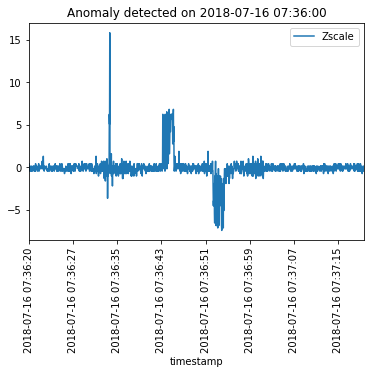

In [18]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 07:36:00")
plt.xticks(rotation=90)

(array([736891.31689815, 736891.31701389, 736891.31712963, 736891.31724537,
        736891.31736111, 736891.31747685]),
 <a list of 6 Text xticklabel objects>)

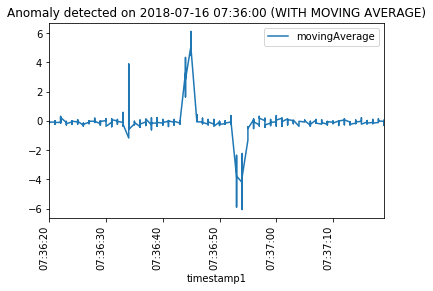

In [19]:
# This is the plot for window size 3

temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 07:36:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

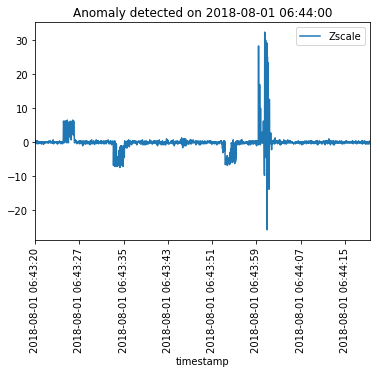

In [25]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-01 06:44:00")
plt.xticks(rotation=90)

(array([736907.28009259, 736907.28020833, 736907.28032407, 736907.28043981,
        736907.28055556, 736907.2806713 ]),
 <a list of 6 Text xticklabel objects>)

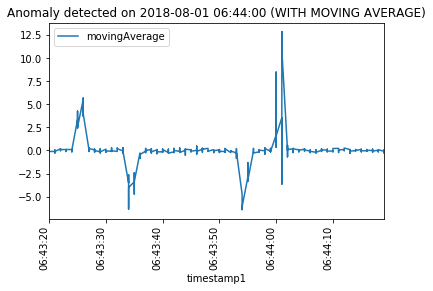

In [26]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-01 06:44:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

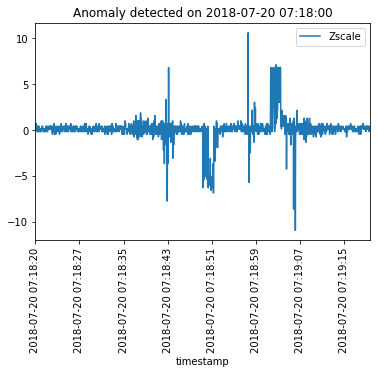

In [32]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-20 07:18:00")
plt.xticks(rotation=90)

(array([736895.30439815, 736895.30451389, 736895.30462963, 736895.30474537,
        736895.30486111, 736895.30497685]),
 <a list of 6 Text xticklabel objects>)

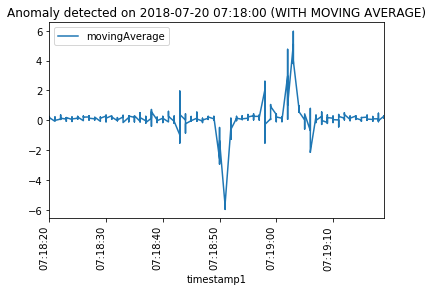

In [33]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-20 07:18:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

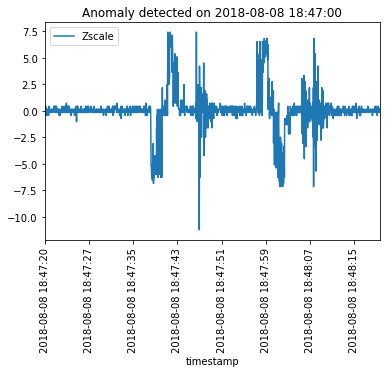

In [40]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 18:47:00")
plt.xticks(rotation=90)

(array([736914.78287037, 736914.78298611, 736914.78310185, 736914.78321759,
        736914.78333333, 736914.78344907]),
 <a list of 6 Text xticklabel objects>)

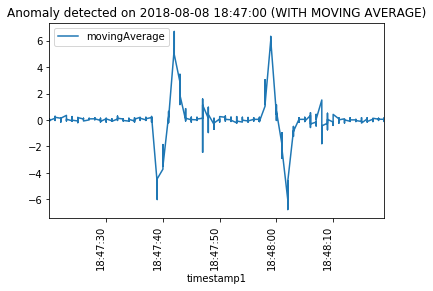

In [41]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 18:47:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

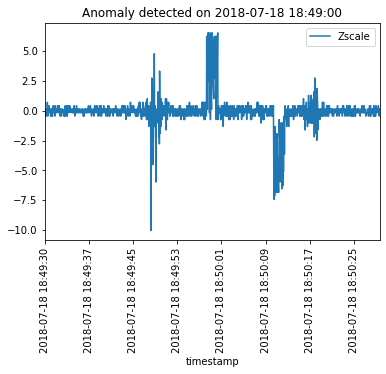

In [53]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 18:49:00")
plt.xticks(rotation=90)

(array([736893.784375  , 736893.78449074, 736893.78460648, 736893.78472222,
        736893.78483796, 736893.7849537 ]),
 <a list of 6 Text xticklabel objects>)

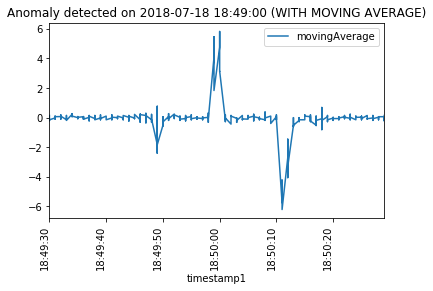

In [54]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 18:49:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text xticklabel objects>)

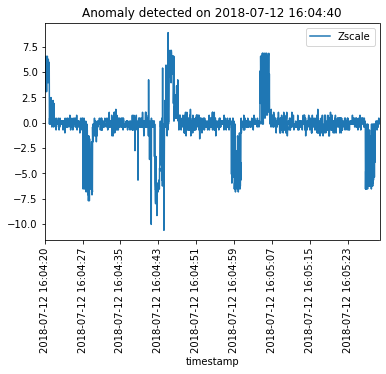

In [67]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 16:04:40")
plt.xticks(rotation=90)

(array([736887.66967593, 736887.66979167, 736887.66990741, 736887.67002315,
        736887.67013889, 736887.67025463, 736887.67037037]),
 <a list of 7 Text xticklabel objects>)

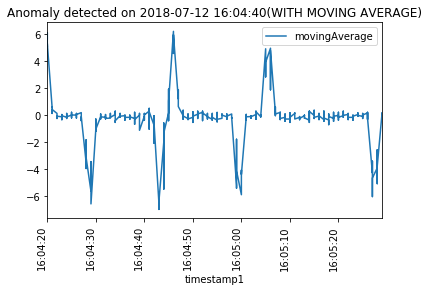

In [68]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 16:04:40(WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

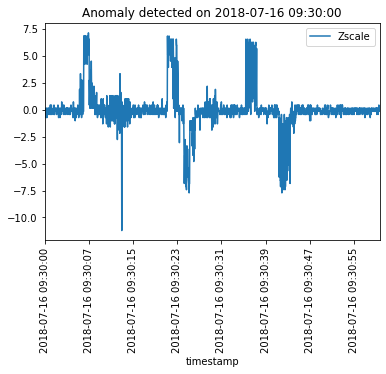

In [75]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 09:30:00")
plt.xticks(rotation=90)

(array([736891.39583333, 736891.39594907, 736891.39606481, 736891.39618056,
        736891.3962963 , 736891.39641204]),
 <a list of 6 Text xticklabel objects>)

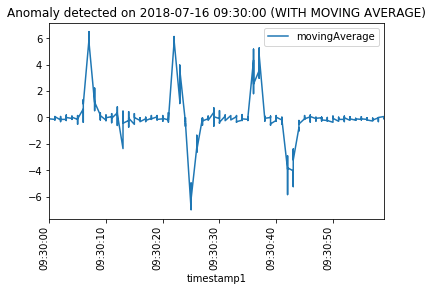

In [76]:

temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 09:30:00 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

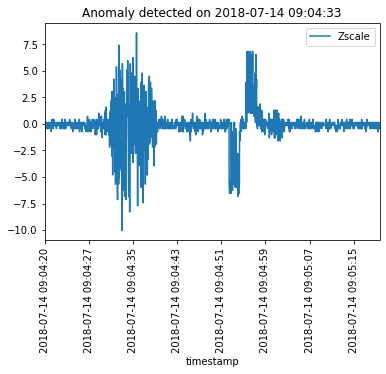

In [82]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-14 09:04:33")
plt.xticks(rotation=90)

(array([736889.37800926, 736889.378125  , 736889.37824074, 736889.37835648,
        736889.37847222, 736889.37858796]),
 <a list of 6 Text xticklabel objects>)

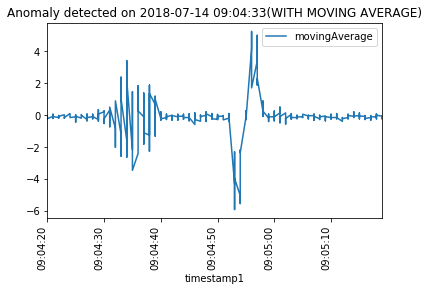

In [83]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-14 09:04:33(WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text xticklabel objects>)

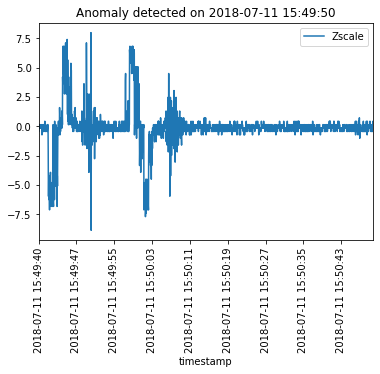

In [90]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 15:49:50")
plt.xticks(rotation=90)

(array([736886.65949074, 736886.65960648, 736886.65972222, 736886.65983796,
        736886.6599537 , 736886.66006944, 736886.66018519]),
 <a list of 7 Text xticklabel objects>)

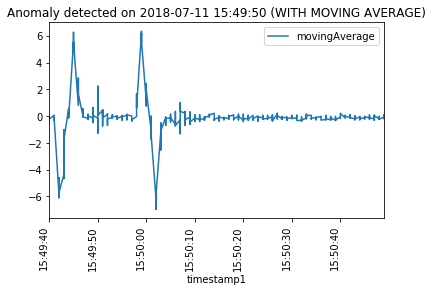

In [91]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 15:49:50 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

### Anomaly10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

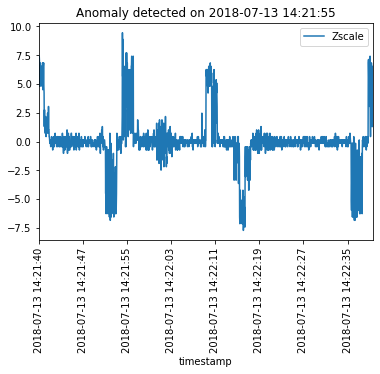

In [134]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 14:21:55")
plt.xticks(rotation=90)

(array([736888.59837963, 736888.59849537, 736888.59861111, 736888.59872685,
        736888.59884259, 736888.59895833]),
 <a list of 6 Text xticklabel objects>)

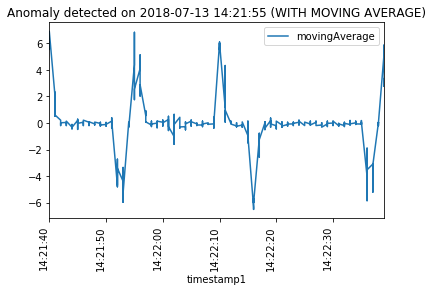

In [135]:

# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 14:21:55 (WITH MOVING AVERAGE)")
plt.xticks(rotation=90)

## Normal Cases

In [193]:
scaledNorm.createOrReplaceTempView("scale")
normaldata = spark.sql("select timestamp,Z,Zscale from scale where Zround = 7")
normaldata.show(truncate=False) 

+-----------------------+--------+--------+
|timestamp              |Z       |Zscale  |
+-----------------------+--------+--------+
|2018-07-09 20:32:40.721|1.246094|6.542904|
|2018-07-09 15:11:33.064|1.25    |6.833955|
|2018-07-09 13:03:16.061|1.246094|6.542904|
|2018-07-09 20:46:50.322|1.246094|6.542904|
|2018-07-09 12:55:31.933|1.246094|6.542904|
|2018-07-09 20:12:13.290|1.246094|6.542904|
|2018-07-09 15:44:01.323|1.246094|6.542904|
|2018-07-09 20:27:50.848|1.246094|6.542904|
|2018-07-09 18:15:49.596|1.25    |6.833955|
|2018-07-09 14:33:40.380|1.25    |6.833955|
|2018-07-09 16:29:24.697|1.246094|6.542904|
|2018-07-09 16:13:50.447|1.246094|6.542904|
|2018-07-09 17:17:20.092|1.246094|6.542904|
|2018-07-09 14:53:52.523|1.253906|7.125006|
|2018-07-09 13:24:57.293|1.25    |6.833955|
|2018-07-09 16:01:54.909|1.246094|6.542904|
|2018-07-09 14:26:18.742|1.25    |6.833955|
|2018-07-09 19:40:37.916|1.246094|6.542904|
|2018-07-09 16:44:21.145|1.25    |6.833955|
|2018-07-09 12:40:33.099|1.25   

In [197]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select SUBSTRING_INDEX(timestamp, '.', 1) as timestamp,Zscale from scaledData where timestamp between '2018-07-09 20:27:00' and '2018-07-09 20:28:00' ORDER BY timestamp ASC ").cache()

In [198]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time temp_pandas = temp_df.select("*").toPandas()

+-------------------+---------+-------------------+
|          timestamp|   Zscale|         timestamp1|
+-------------------+---------+-------------------+
|2018-07-09 20:27:00|-5.973098|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.846325|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.555199|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-5.682047|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-5.682047|2018-07-09 20:27:00|
|2018-07-09 20:27:00| -4.51777|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-5.973098|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-5.099871|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.264149|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.846325|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.846325|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.555199|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-6.555199|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-7.137376|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-7.137376|2018-07-09 20:27:00|
|2018-07-09 20:27:00|-5.682047|2018-07-09 20:27:00|
|2018-07-09 

### Normal Case 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

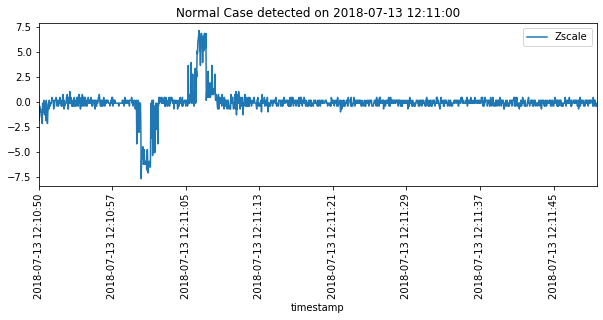

In [188]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.rcParams["figure.figsize"] = (10,3)
plt.title("Normal Case detected on 2018-07-13 12:11:00")

plt.xticks(rotation=90)

### Normal Case 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

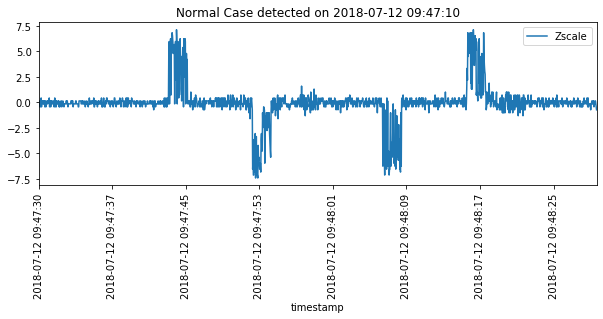

In [172]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.rcParams["figure.figsize"] = (10,3)
plt.title("Normal Case detected on 2018-07-12 09:47:10")

plt.xticks(rotation=90)

### Normal Case 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

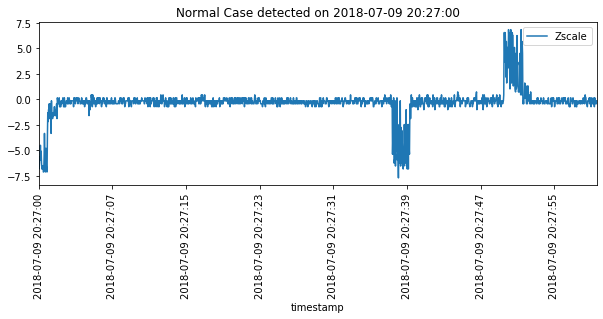

In [199]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.rcParams["figure.figsize"] = (10,3)
plt.title("Normal Case detected on 2018-07-09 20:27:00")

plt.xticks(rotation=90)